<a href="https://colab.research.google.com/github/Pavitra-khare/DA6401_ASS_2A/blob/main/DA6401_ASS_2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login(key="bad0d13cb33ad3ab10579145135ecdce4cd371f0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 3628-pavitrakhare (3628-pavitrakhare-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import wandb
from types import SimpleNamespace
import random



In [3]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def img_size(img_w, filter_size, padding, stride):
    """Calculate the output size after convolution and pooling.
    Args:
    img_w: Width of the input image
    filter_size: Size of the filter/kernel
    padding: Padding applied to the input
    stride: Stride used in the convolution

Returns:
    The output dimension after convolution and pooling
"""
# Calculate the output size after convolution
    conv_output = (img_w - filter_size + (2 * padding)) / stride + 1

# Apply pooling (dividing by 2)
    pooled_output = conv_output / 2

    return pooled_output

#ques1

In [4]:
class ConvNet(nn.Module):
    """
    CNN with 5 convolutional layers + fully connected layers for classification.
    """
    def __init__(self, in_channels=3, num_filters=[32, 64, 128, 256, 512],
                 filter_size=[3, 3, 5, 5, 7], activation=nn.ReLU(),
                 stride=1, padding=1, pool_size=(2, 2), fc_size=512,
                 num_classes=10, dropout=0, batch_norm='Yes'):
        super(ConvNet, self).__init__()

        # Save model settings
        self.config = {
            'channels': in_channels,
            'num_filters': num_filters,
            'filter_size': filter_size,
            'activation': activation,
            'stride': stride,
            'padding': padding,
            'pool_size': pool_size,
            'fc_size': fc_size,
            'num_classes': num_classes,
            'dropout': dropout,
            'batch_norm': batch_norm
        }

        # Create 5 convolutional blocks
        self.conv_blocks = nn.ModuleList()
        in_channels_list = [in_channels] + num_filters[:-1]

        for i in range(5):
            block = nn.Sequential()
            block.add_module(f'conv{i+1}', nn.Conv2d(in_channels_list[i], num_filters[i],
                                                     filter_size[i], stride=stride, padding=padding))

            # Optional batch norm
            if batch_norm == 'Yes':
                block.add_module(f'bn{i+1}', nn.BatchNorm2d(num_filters[i]))

            block.add_module(f'act{i+1}', activation)         # Activation function
            block.add_module(f'pool{i+1}', nn.MaxPool2d(pool_size, stride=2))  # Max pooling
            block.add_module(f'drop{i+1}', nn.Dropout2d(dropout))              # Dropout layer

            self.conv_blocks.append(block)

        # Compute final feature map size for fully connected layer
        input_size = 224
        for i in range(5):
            input_size = self._calculate_output_size(input_size, filter_size[i], padding, stride)

        # Fully connected classifier
        self.classifier = nn.Sequential()
        self.classifier.add_module('fc', nn.Linear(num_filters[4] * (int(input_size) ** 2), fc_size))

        if batch_norm == 'Yes':
            self.classifier.add_module('fc_bn', nn.BatchNorm1d(fc_size))

        self.classifier.add_module('fc_act', activation)   # Activation
        self.classifier.add_module('fc_drop', nn.Dropout(dropout))  # Dropout
        self.classifier.add_module('output', nn.Linear(fc_size, num_classes))  # Output layer

    def _calculate_output_size(self, img_size, kernel_size, padding, stride):
        # Compute output size after conv and pooling
        conv_output = (img_size - kernel_size + 2*padding) / stride + 1
        return conv_output / 2

    def forward(self, x):
        # Pass input through convolutional layers
        for block in self.conv_blocks:
            x = block(x)

        # Flatten before fully connected layers
        x = x.reshape(x.size(0), -1)

        # Pass through classifier
        return self.classifier(x)

# Instantiate the model and move to device
model = ConvNet().to(device)
print(model)


ConvNet(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (drop1): Dropout2d(p=0, inplace=False)
    )
    (1): Sequential(
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
      (drop2): Dropout2d(p=0, inplace=False)
    )
    (2): Sequential(
      (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU()
      (pool3): MaxPoo

#Ques2

In [ ]:
def test_on_valid_data(model, test_data):

# Switch to evaluation mode
    model.eval()

# Initialize counters
    correct_predictions = 0
    total_samples = 0

# Disable gradient computation for efficiency
    with torch.no_grad():
    # Iterate through batches
        for inputs, targets in test_data:
        # Move data to appropriate device
            inputs = inputs.to(device)
            targets = targets.to(device)

        # Forward pass
            outputs = model(inputs)

        # Get predictions
            _, predicted_classes = torch.max(outputs, dim=1)

        # Update statistics
            correct_predictions += (predicted_classes == targets).sum().item()
            total_samples += targets.size(0)

# Calculate accuracy percentage
    accuracy = (correct_predictions / total_samples) * 100

    return accuracy

In [ ]:
def model_train_val(model, train_data, val_data, epochs):
    highest_val_accuracy = 0      # Store the best validation accuracy achieved
    early_stop_limit = 2          # Max number of epochs without improvement
    stagnation_counter = 0        # Count epochs without improvement

    best_model_state = None       # To store the best model weights

    for current_epoch in range(epochs):
        # Perform training step and gather metrics
        model, loss_value, training_accuracy = train_on_train_data(model, train_data)
        validation_accuracy = test_on_valid_data(model, val_data)

        # Record metrics to Weights & Biases
        wandb.log({
            'Train loss': loss_value,
            'Train accuracy': training_accuracy,
            'val_accuracy': validation_accuracy,
            'epoch': current_epoch
        })

        # Display current epoch stats
        print(f"Epoch {current_epoch + 1}/{epochs} | Loss: {loss_value:.4f} | "
              f"Train Acc: {training_accuracy:.2f}% | Val Acc: {validation_accuracy:.2f}%")

        # Check if validation accuracy improved
        if validation_accuracy > highest_val_accuracy:
            highest_val_accuracy = validation_accuracy
            stagnation_counter = 0
            best_model_state = model.state_dict()  # Save best model weights
        else:
            stagnation_counter += 1
            if stagnation_counter >= early_stop_limit:
                print(f"Training stopped early at epoch {current_epoch + 1} due to no improvement.")
                break

    # Restore best model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model restored based on validation accuracy.")

    return model


In [ ]:
# Function to train the model on training dataset
def train_on_train_data(model, train_data):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()  # Switch model to training mode

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate through the training dataset
    for batch_images, batch_labels in train_data:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()  # Reset gradients to zero
        predictions = model(batch_images)  # Forward pass
        loss = loss_function(predictions, batch_labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss value

        # Calculate correct predictions (using .argmax())
        predicted_classes = predictions.argmax(dim=1)  # Get the class with max probability
        correct_predictions += (predicted_classes == batch_labels).sum().item()  # Count correct predictions

        total_samples += batch_labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_data)
    accuracy = 100 * correct_predictions / total_samples

    return model, avg_loss, accuracy


In [ ]:
# Function to load training and validation data with optional data augmentation


    #train_data_directory = '/content/drive/MyDrive/DA6401_ASS2_DATASET/inaturalist_12K/train'
def data_load(train_data_directory, use_data_augmentation):
    # Define image transformations
    resize = transforms.Resize((224, 224))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_crop = transforms.RandomResizedCrop(224)
    flip = transforms.RandomHorizontalFlip()
    jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rotation = transforms.RandomRotation(20)

    # Apply data augmentation if enabled
    if use_data_augmentation == 'Yes':
        transformation_pipeline = transforms.Compose([
            random_crop, flip, jitter, rotation, to_tensor, normalize
        ])
    else:
        transformation_pipeline = transforms.Compose([resize, to_tensor, normalize])

    # Load dataset using ImageFolder and apply transformations
    dataset = ImageFolder(root=train_data_directory, transform=transformation_pipeline)

    # Split the dataset into training and validation subsets
    train_indices, validation_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

    # Create samplers for training and validation data
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)

    # Load data into DataLoader with the defined batch size and parallel processing
    training_loader = DataLoader(
        dataset,
        batch_size=32,
        sampler=train_sampler,
        num_workers=4,  # Parallel loading
        pin_memory=True  # Faster data transfer to GPU
    )

    validation_loader = DataLoader(
        dataset,
        batch_size=32,
        sampler=validation_sampler,
        num_workers=4,  # Parallel loading
        pin_memory=True  # Faster data transfer to GPU
    )

    return training_loader, validation_loader


In [ ]:
# Function to load test data with optional data augmentation

#test_data_directory = '/content/drive/MyDrive/DA6401_ASS2_DATASET/inaturalist_12K/val'

def test_data_load(test_data_directory, apply_data_augmentation):
    # Define the transformations to apply to the test images
    resize = transforms.Resize((224, 224))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_crop = transforms.RandomResizedCrop(224)
    flip = transforms.RandomHorizontalFlip()
    jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    rotation = transforms.RandomRotation(20)

    # Choose whether to apply data augmentation based on user input
    if apply_data_augmentation == 'Yes':
        transformation_pipeline = transforms.Compose([
            random_crop, flip, jitter, rotation, to_tensor, normalize
        ])
    else:
        transformation_pipeline = transforms.Compose([resize, to_tensor, normalize])

    # Load test data using ImageFolder and apply transformations
    dataset = ImageFolder(root=test_data_directory, transform=transformation_pipeline)

    # Load the dataset into DataLoader for batch processing
    test_loader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=4,  # Use multiple workers for faster data loading
        pin_memory=True  # Enable faster memory transfer to GPU
    )

    return test_loader


In [ ]:
# Modified configuration for hyperparameter sweep
sweep_configuration = {
    'method': 'bayes',  # Bayesian optimization method for hyperparameter tuning
    'metric': {
        'name': 'val_accuracy',  # Metric to optimize
        'goal': 'maximize'  # The goal is to maximize validation accuracy
    },
    'parameters': {
        'data_aug': {
            'values': ['Yes', 'No']  # Whether to apply data augmentation or not
        },
        'dropout': {
            'values': [0.2, 0.3]  # Dropout rates to test
        },
        'activation': {
            'values': ['gelu', 'silu', 'relu', 'mish']  # Different activation functions to experiment with
        },
        'filter_org': {
            'values': [[32, 32, 32, 32, 32], [128, 128, 64, 64, 32], [32, 64, 128, 256, 512], [32, 64, 64, 128, 128]]  # Filter configurations for convolution layers
        },
        'kernel_size': {
            'values': [[5, 5, 5, 5, 5], [3, 5, 3, 5, 7], [3, 5, 5, 7, 7], [3, 3, 3, 3, 3]]  # List of possible kernel sizes
        },
        'batch_norm': {
            'values': ['No', 'Yes']  # Whether to use batch normalization or not
        },
        'num_dense': {
            'values': [256, 128]  # Number of units in dense layers
        }
    }
}

# Start the sweep process using wandb
sweep_id = wandb.sweep(sweep_configuration, project="DL_ASS2_image")


In [ ]:
def main():
    '''
    The main function is invoked by WandB for each combination of hyperparameters.

    We retrieve the hyperparameter values from `wandb.config` and use them to configure the model.
    '''

    with wandb.init() as run:
        # Construct a unique run name based on hyperparameter values
        run_name = f"ks{wandb.config.kernel_size}_ac-{wandb.config.activation}_drop-{wandb.config.dropout}_daug-{wandb.config.data_aug}_fs-{wandb.config.filter_org}_bn-{wandb.config.batch_norm}_dence-{wandb.config.num_dense}"
        wandb.run.name = run_name  # Set the run name

        # Select activation function based on hyperparameter configuration
        if wandb.config.activation == 'relu':
            activ = nn.ReLU()
        elif wandb.config.activation == 'gelu':
            activ = nn.GELU()
        elif wandb.config.activation == 'silu':
            activ = nn.SiLU()
        elif wandb.config.activation == 'mish':
            activ = nn.Mish()

        # Create model instance with selected hyperparameters
        model = ConvNet(
            num_filters=wandb.config.filter_org,
            activation=activ,
            in_channels=3,
            batch_norm=wandb.config.batch_norm,
            padding=1,
            dropout=wandb.config.dropout,
            filter_size=wandb.config.kernel_size,
            stride=1,
            num_classes=10,
            pool_size=(2, 2),
            fc_size=wandb.config.num_dense
        ).to(device)

        # Directory for training data
        train_data_dir = '/kaggle/input/my-dataset/inaturalist_12K/train'

        # Load training and validation data with data augmentation based on configuration
        train, validation = data_load(train_data_dir, use_data_augmentation=wandb.config.data_aug)

        # Train and validate the model for 7 epochs
        model_train_val(model, train, validation, epochs=7)

# Initialize WandB agent to run the main function with the defined hyperparameters
wandb.agent(sweep_id, function=main, count=200)  # Run for a single combination
wandb.finish()  # Finish the run


#ques 4 Best Model

In [1]:
#Best model config
# num_filters=[32,64,128,256,512]
# filter_size=[3, 3, 3, 3, 3]
# activation=nn.GELU()
# fc_size=256
# dropout=0.2
# batch_norm = 'Yes'
# data_augmentation = 'No'
# epochs = 7

In [ ]:
import imageio.v2
import os
import cv2
from PIL import Image

def img_plot(model):
    #For plotting random Images
    classes_list = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
    # Directory of the test data
    dir = '/kaggle/input/my-dataset/inaturalist_12K/val'
    images = []  # List to store the images
    labels = []  #  List to store the labels

    for label, name in enumerate(classes_list):
      images_list = os.listdir(dir+'/'+name)
      img_names = []
      for j in range(3):
        index = random.randint(0, 199)
        img_names.append(images_list[index])
      for image_name in img_names:
          image = imageio.v2.imread(dir+'/'+name+'/'+image_name)
          if np.ndim(image) == 3:
            images.append(cv2.resize(image, (224,224)))
            labels.append(classes_list[label])

    arr = np.array(images)
    arr = (arr/255.0).astype('float32')
    transp_arr = np.transpose(arr, (0, 3, 1, 2))
    tensor1 = torch.tensor(transp_arr).to(device)
    y_pred = model(tensor1)
    y_pred_label = torch.argmax(y_pred, 1)
    dictn = {0:'Amphibia',1:'Animalia',2:'Arachnida',3:'Aves',4:'Fungi',
               5:'Insecta',6:'Mammalia',7:'Mollusca',8:'Plantae',9:'Reptilia'}

    fig, axes = plt.subplots(10, 3, figsize=(12, 20))
    for i in range(10):
        for j in range(3):
            ind = i * 3 + j
            if ind < 30:
                axes[i, j].imshow(images[ind])

                # Get the predicted label
                pred_label = dictn[y_pred_label[ind].item()]  # Fixed 'idx' to 'ind'

                # Set color based on prediction correctness
                color = 'green' if pred_label == labels[ind] else 'red'

                # Set title with colored text
                axes[i, j].set_title(f'True: {labels[ind]}, Predicted: {pred_label}', color=color)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig('pictures.png', bbox_inches='tight')
    # Convert the saved image to Image
    image = Image.open('pictures.png')
    fig.canvas.draw()
    image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    wandb.log({"images": [wandb.Image(image, caption="Test image prediction")]})


In [ ]:
def model_train_test(model, train_data, test_data, epochs):
    """
    Trains the given model using the training dataset, evaluates on test data,
    and visualizes predictions.
    """
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=0.001)

    for ep in range(epochs):
        model, train_loss, train_acc = train_on_train_data(model, train_data)

        # Training performance
        print(f"[Epoch {ep + 1}/{epochs}] Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
        wandb.log({'Train loss': train_loss, 'Train accuracy': train_acc})

    # Evaluation on test data
    test_acc = test_on_valid_data(model, test_data)

    # Visual output of predictions
    img_plot(model)

    print(f"[Epoch {ep + 1}/{epochs}] Validation Accuracy: {test_acc:.2f}%")
    wandb.log({'test_accuracy': test_acc, 'epoch': ep})

    wandb.finish()
    print("Training complete!")


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
    'dropout': {
            'values': [0.2]
        },
    'num_dense':{
            'values': [256]
        },

        'kernel_size':{
            'values': [[3,3,3,3,3]]
        },
        'filter_org':{
            'values': [[32,64,128,256,512]]
        },
        'batch_norm':{
            'values': ['Yes']
        },

        'activation': {
            'values': [ 'gelu']
        },

        'data_aug': {
            'values': ['No']
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DL_ASS2_image')


Create sweep with ID: 6zx0jhzj
Sweep URL: https://wandb.ai/3628-pavitrakhare-indian-institute-of-technology-madras/DL_ASS2_image/sweeps/6zx0jhzj


wandb: Agent Starting Run: mkuv54ha with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	num_dense: 256


[Epoch 1/10] Loss: 2.1444 | Accuracy: 22.90%
[Epoch 2/10] Loss: 2.0479 | Accuracy: 26.69%
[Epoch 3/10] Loss: 1.9748 | Accuracy: 28.80%
[Epoch 4/10] Loss: 1.9197 | Accuracy: 31.69%
[Epoch 5/10] Loss: 1.8707 | Accuracy: 33.12%
[Epoch 6/10] Loss: 1.8192 | Accuracy: 36.17%
[Epoch 7/10] Loss: 1.7902 | Accuracy: 36.52%
[Epoch 8/10] Loss: 1.7390 | Accuracy: 38.42%
[Epoch 9/10] Loss: 1.6807 | Accuracy: 41.62%
[Epoch 10/10] Loss: 1.6310 | Accuracy: 42.07%


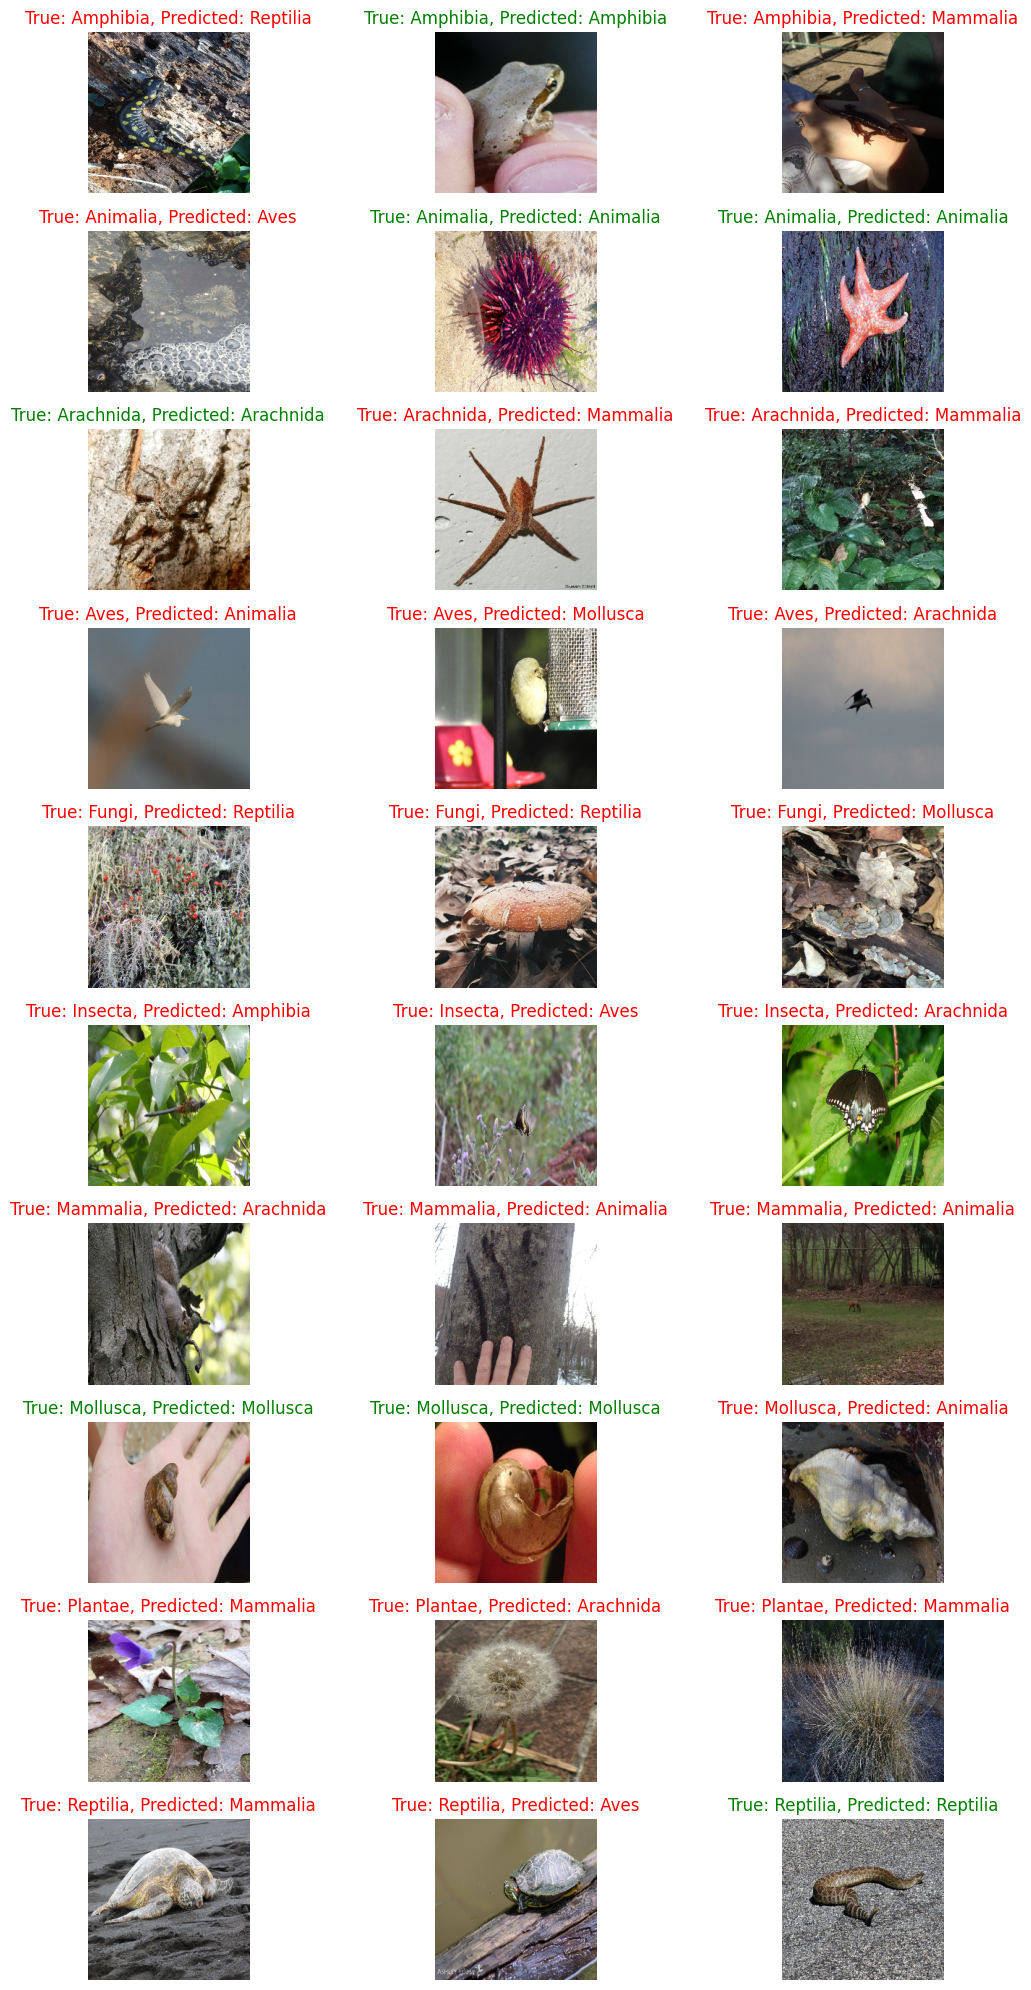

[Epoch 10/10] Validation Accuracy: 38.25%


Train accuracy,▁▂▃▄▅▆▆▇██
Train loss,█▇▆▅▄▄▃▂▂▁
epoch,▁
test_accuracy,▁
Train accuracy,42.06776
Train loss,1.63102
epoch,9
test_accuracy,38.25


Training complete!


In [ ]:
def main():
    """
    Entry point for WandB sweep agent.
    Configures model and data using sweep parameters.
    """

    with wandb.init() as run:
        cfg = wandb.config

        # Constructing a unique run name based on hyperparameters
        run_id = f"ks{cfg.kernel_size}_ac-{cfg.activation}_drop-{cfg.dropout}_daug-{cfg.data_aug}_fs-{cfg.filter_org}_bn-{cfg.batch_norm}_dense-{cfg.num_dense}"
        run.name = run_id

        # Activation function selection
        activation_map = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }
        selected_activation = activation_map.get(cfg.activation.lower(), nn.ReLU())

        # Initialize model with sweep-configured parameters
        cnn_model = ConvNet(
            in_channels=3,
            num_filters=cfg.filter_org,
            dropout=cfg.dropout,
            filter_size=cfg.kernel_size,
            num_classes=10,
            activation=selected_activation,
            pool_size=(2, 2),
            stride=1,
            batch_norm=cfg.batch_norm,
            fc_size=cfg.num_dense,
            padding=1,
        ).to(device)


        # Load datasets
        train_path = '/kaggle/input/my-dataset/inaturalist_12K/train'
        test_path = '/kaggle/input/my-dataset/inaturalist_12K/val'

        training_data, validation_data = data_load(train_path, use_data_augmentation=cfg.data_aug)
        testing_data = test_data_load(test_path, apply_data_augmentation=cfg.data_aug)

        # Train and evaluate model
        model_train_test(cnn_model, training_data, testing_data, epochs=10)

# Launch wandb agent with specified sweep
wandb.agent(sweep_id, function=main, count=1)
wandb.finish()
